## FlexibelNoise: plot sd(x) + its regressors

In [1]:
import os.path as op
import os
import numpy as np
import pandas as pd
import arviz as az


bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, f'derivatives/cogmodels_risk')
format = 'symbolic'

from utils import get_data  
df = get_data(bids_folder)
df = df.xs(format,0, level='format')

number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [2]:
import pandas as pd
import numpy as np

def get_pars(trace, model,par = ''):
    n_polynomials = 5

    intercept_pars = pd.concat([trace.posterior[f'{par}evidence_sd_spline{spline_n}_mu'].to_dataframe().xs('Intercept', level=-1) for spline_n in range(1, n_polynomials+1)], axis=1)
    group_pars =  pd.concat([trace.posterior[f'{par}evidence_sd_spline{spline_n}_mu'].to_dataframe().xs('group', level=-1) for spline_n in range(1, n_polynomials+1)], axis=1)

    control = intercept_pars
    dyscalculic = intercept_pars + group_pars

    x = np.linspace(5, 90)
    
    dm = model.make_dm(x, variable=f'{par}evidence_sd')
    evidence_sd_c = pd.DataFrame(dm.dot(control.T),
                                        index=pd.Index(x, name='x'),
                                        columns=control.index).stack([0, 1]).to_frame('sd')

    evidence_sd_d = pd.DataFrame(dm.dot(dyscalculic.T),
                                            index=pd.Index(x, name='x'),
                                            columns=dyscalculic.index).stack([0, 1]).to_frame('sd')

    evidence_sd = pd.concat([evidence_sd_c, evidence_sd_d], keys=['control', 'dyscalculic'], names=['group'], axis=0)

    return evidence_sd #control, dyscalculic

import arviz as az
def get_hdi(d):
    return pd.Series(az.hdi(d.values, hdi_prob=0.95), index=['hdi025', 'hdi975'])


number of subjects in dataframe: 63
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54,
            55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')
{'evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'prior_mu': {'mu_intercept': 23.31427856129517, 'sigma_intercept': 25.0, 'transform': 'identity'}, 'prior_sd': {'mu_intercept': 23.31427856129517

/Users/mrenke/git/bauer/bauer/models.py:1527: UserWarning: Found evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')


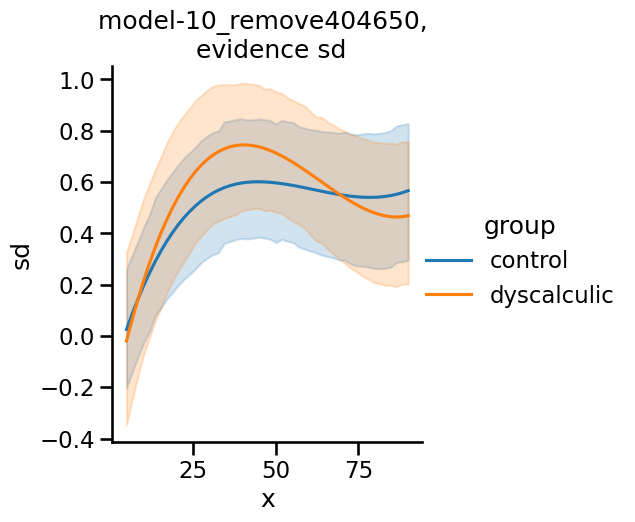

In [8]:
import seaborn as sns
from utils_02 import build_model
sns.set_context('talk')
from os import listdir

model_label = '10'
format = 'symbolic'
remove_404650 = True

if remove_404650:
    subject_list = [f[4:] for f in listdir(bids_folder) if f[0:3] == 'sub' and len(f) == 6]
    subject_list = [subject for subject in subject_list if subject not in ['40', '46', '50']]
    df = get_data(bids_folder,subject_list)

model = build_model(model_label, df)
model.build_estimation_model()

if remove_404650:
    model_label = f'{model_label}_remove404650'
trace = az.from_netcdf(op.join(target_folder, f'model-{model_label}_format-{format}_trace.netcdf'))

evidence_sd = get_pars(trace,model)
g = sns.relplot(data=evidence_sd.reset_index(), x='x', y='sd', hue='group', kind='line', errorbar=get_hdi)
g.set(title=f'model-{model_label}, \n evidence sd')

[(5.0, 28.0), (-0.5, 0.5)]

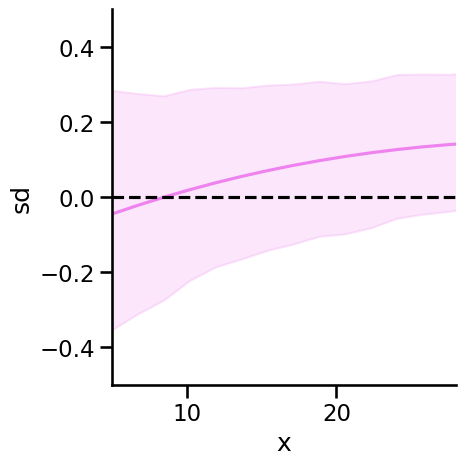

In [9]:
import matplotlib.pyplot as plt
evidence_sd_diff = evidence_sd.xs('dyscalculic',0,level='group') - evidence_sd.xs('control',0,level='group')

g = sns.relplot(data=evidence_sd_diff.reset_index(), x='x', y='sd', kind='line', errorbar=get_hdi, facet_kws={'sharex': False}, color='violet')
for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--')
g.axes[0,0].set(xlim=[5,28],ylim=[-0.5,0.5])


### 2 x evidence sd (risky & safe)

In [5]:
import seaborn as sns
from utils_02 import build_model

sns.set_context('talk')

model_label = '9reg'
format = 'symbolic'
model = build_model(model_label, df)
model.build_estimation_model()
trace = az.from_netcdf(op.join(target_folder, f'model-{model_label}_format-{format}_trace.netcdf'))

/Users/mrenke/git/bauer/bauer/models.py:1527: UserWarning: Found n1_evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')
/Users/mrenke/git/bauer/bauer/models.py:1527: UserWarning: Found n2_evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')


{'n1_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n1_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline1': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline2': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline3': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline4': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'n2_evidence_sd_spline5': {'mu_intercept': 5.0, 'sigma_intercept': 5.0, 'transform': 'identity'}, 'risky_prior_mu': {

[(0.0, 1.5)]

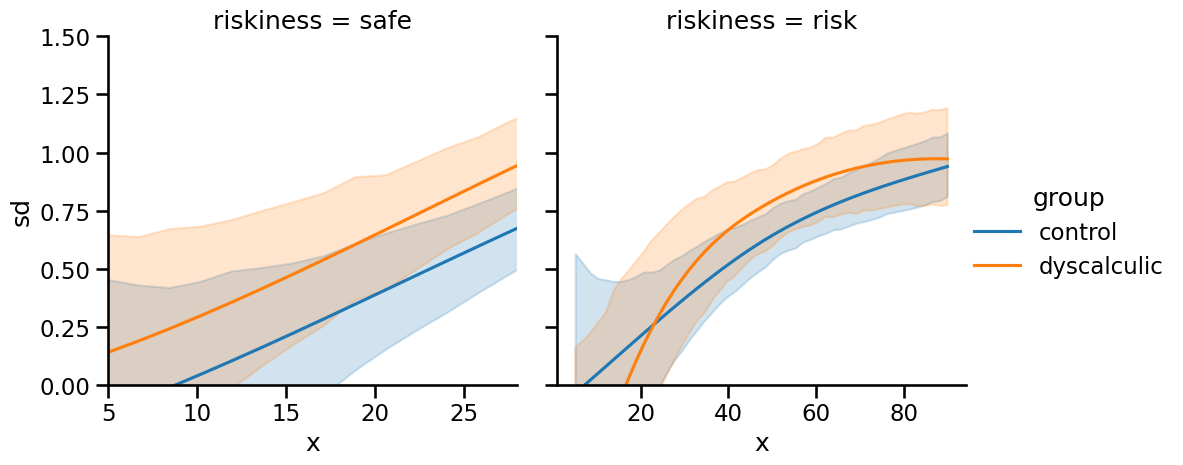

In [6]:
safe_evidence_sd = get_pars(trace,model,par='n1_')
risk_evidence_sd = get_pars(trace,model,par='n2_')

evidence_sd = pd.concat([safe_evidence_sd, risk_evidence_sd], keys=['safe', 'risk'], names=['riskiness'], axis=0)

g = sns.relplot(data=evidence_sd.reset_index(), x='x', y='sd', hue='group', col='riskiness', kind='line', errorbar=get_hdi, facet_kws={'sharex': False})
g.axes[0,0].set(xlim=[5,28],ylim=[0,1])
g.axes[0,1].set(ylim=[0,1.5])

In [ ]:
import matplotlib.pyplot as plt
evidence_sd_diff = evidence_sd.xs('dyscalculic',0,level='group') - evidence_sd.xs('control',0,level='group')

g = sns.relplot(data=evidence_sd_diff.reset_index(), x='x', y='sd', col='riskiness', kind='line', errorbar=get_hdi, facet_kws={'sharex': False}, color='violet')
for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--')
g.axes[0,0].set(xlim=[5,28],ylim=[-0.5,0.5])
